**Agentes** Use la clase agente para modelar una epidemia Zombie como se describe en [Agent-Based Computational Model of Humanity’s Prospects for Post Zombie Outbreak Survival](http://thetortoiseslens.blogspot.mx/2010/03/agent-based-computational-model-of.html). Utiliza el diagrama del artículo _SimZombie: A Case-Study in Agent-Based Simulation Construction_ como guía.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

random.seed(10)

class Agente:
    """ Agente general """
    def __init__(self, tipo, locacion=np.array([0,0])):
        self.tipo = tipo
        self.locacion = locacion
        self.siguiente_accion = None

    def distancia(self, otro):
        "Calcula la distancia euclídea entre este agente y otro."
        return np.linalg.norm(self.locacion - otro.locacion)  # Otra manera es usar np.sqrt(np.sum((a-b)**2))
    
    def vecinos(self, agentes):
        pass
    
    def actuar(self, agentes):
        self.locacion =  self.siguiente_accion
        
    def decidir(self, agentes):
        self.siguiente_accion = np.array([random.uniform(0, 1), random.uniform(0, 1)]) # Toma una nueva posición al azar
    
    def actualizar(self, agentes):
        self.decidir(agentes)
        self.actuar(agentes)
        
class Mundo:
    def __init__(self, agentes, ancho=8, alto=8, steps = 10):
        self.agentes = agentes
        self.ancho = ancho
        self.alto = alto
        self.steps = steps
        self.init_anim()
        
        print ("Creado el mundo")
        
    def init_anim(self):
        self.fig = plt.figure(figsize=(self.ancho, self.alto))
        self.ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
        plot_args = {'markersize' : 8, 'alpha' : 0.6}
        self.puntos, = self.ax.plot([], [], 'o', **plot_args)
       
       
    def dibujar(self, step):
        x_values_0, y_values_0 = [], []
        for agente in self.agentes:
            x, y = agente.locacion
            x_values_0.append(x)
            y_values_0.append(y)

        self.puntos.set_data(x_values_0, y_values_0)
        
        self.ax.set_title('Paso {}'.format(step))
        
        return self.puntos,
       
    def actualizar(self, step):   
        self.dibujar(step) # Dibuja el mundo
        
        for agente in self.agentes:
            agente.actualizar(self.agentes)
    
    def clean_screen(self):
        self.puntos.set_data([], [])
        return self.puntos,
          
    def simular(self):
        anim = animation.FuncAnimation(self.fig, self.actualizar, init_func=self.clean_screen, frames=self.steps, interval=1000, blit=False)
        return anim

In [3]:
#tipo 0=human,1=zombie,2=dead
class Agente_Mundo_Zombie(Agente):
    
    def __init__(self, tipo):
        Agente.__init__(self, tipo)
        self.speed = 0
        if tipo == 1:
            self.speed = 0.15
        elif tipo == 2:
            self.speed = 0.1
        self.locacion = np.array([random.uniform(-1,1),random.uniform(-1,1)])
        self.birthRate = (1,10)
        self.naturalDeathRate = (1,10)
        self.zombieDefeatChance = (1,2)
        self.resurrectionRate = (1,10)
        self.posibles_direcciones = (0,1)
                                  
    def actuar(self,agentes):
        v = np.array([random.uniform(-1,1),random.uniform(-1,1)])
        v /= np.linalg.norm(v)
        #self.siguiente_accion = np.array([random.choice(self.posibles_direcciones), random.choice(self.posibles_direcciones)]) 
        if self.tipo == 0:
            aux = self.locacion + v
            funCostoAnt = np.exp(-np.square(self.locacion[0])-np.square(self.locacion[1]))
            funCostoSig = np.exp(-np.square(aux[0])-np.square(aux[1]))
            if funCostoAnt < funCostoSig:
                self.locacion = aux
            else:
                self.locacion = self.locacion    
        elif self.tipo == 1:
            self.locacion = self.locacion + v
        else:
            self.locacion = self.locacion
           
    def decidir(self,agentes):

        #cuando es humano
        #muerte natural
        if self.tipo == 0:
            aux1 = random.choice(self.naturalDeathRate)
            if aux1 == 1:
                self.tipo == 2
        #cuando es zombie
        #infeccion
        elif self.tipo == 1:
            for agente in agentes:
                distanciaAtacar = self.distancia(agente)
                funCostoProb = np.exp(-np.square(self.locacion[0])-np.square(self.locacion[1]))*.80
                aux2 = random.uniform(0,1)
                if distanciaAtacar < 0.05 and funCostoProb < aux2: #si lo ataca
                    agente.tipo = 1
                elif distanciaAtacar < 0.05 and funCostoProb > aux2:
                    self.tipo = 2                    
        #cuando está muerto
        #reanimacion 
        else:
            aux3 = random.choice(self.resurrectionRate)
            if aux3 == 1:
                self.tipo == 1    
        
class Mundo_Zombie(Mundo):
    
    def init_anim(self):
        self.fig = plt.figure(figsize=(self.ancho, self.alto))
        self.ax = plt.axes(xlim=(-1,1), ylim=(-1,1))
        plot_args = {'markersize' : 8, 'alpha' : 0.6}
        self.puntos_r, = self.ax.plot([],[],'+',markerfacecolor="black")
        self.puntos_z, = self.ax.plot([],[],'o',markerfacecolor="red")
        self.puntos_s, = self.ax.plot([],[],'o',markerfacecolor="green")
        self.x = np.linspace(-0.2,0.2,100)
        self.y = np.linspace(-0.2,0.2,100)
        self.X,self.Y = np.meshgrid(self.x,self.y)
        self.Z = np.exp(-np.square(self.X)-np.square(self.Y))
        cp = plt.contour(self.X,self.Y,self.Z)
        plt.clabel(cp,inline=1,fontsize=10)
        
        
    def clean_screen(self):
        self.puntos_r.set_data([],[])
        self.puntos_z.set_data([],[])
        self.puntos_s.set_data([],[])
    
    def dibujar(self,step):
        x_r,y_r=[],[]
        x_z,y_z=[],[]
        x_s,y_s=[],[]
        
        for agente in self.agentes:
            x,y= agente.locacion
            if agente.tipo == 0:
                x_s.append(x)
                y_s.append(y)
            elif agente.tipo == 1:
                x_z.append(x)
                y_z.append(y)
            else:
                x_r.append(x)
                y_r.append(y)
        
        self.puntos_r.set_data(x_r,y_r)
        self.puntos_z.set_data(x_z,y_z)
        self.puntos_s.set_data(x_s,y_s)
        
        self.ax.set_title('Paso {}'.format(step))
        
        return 

Creado el mundo


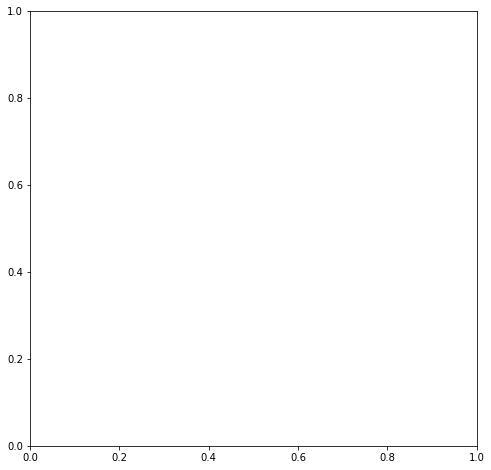

In [4]:
num_tipo0 = 999
num_tipo1 = 1
num_tipo2 = 0

agentes = [Agente_Mundo_Zombie(tipo=0) for i in range(num_tipo0)]
agentes.append(Agente_Mundo_Zombie(tipo=1))

mundo_zombie = Mundo_Zombie(agentes = agentes, steps=100)

sim_zombie = mundo_zombie.simular()

In [5]:
HTML(sim_zombie.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x1 = np.linspace(-10.0,10.0,100)
x2 = np.linspace(-10.0,10.0,100)
plt.scatter(x1,x2)
plt.show()
a=np.array((1,2,3))
#Ejemplo meshgrid
a1,a2=np.meshgrid(a,a)
#a1,a2 meshgrid regresa dos matrices, la primera tiene repetida los datos en las filas y la otra en las columnas

X1,X2=np.meshgrid(x1,x2)
Y=np.sqrt(np.square(X1)+np.square(X2))
cm=plt.cm.get_cmap('viridis')
plt.scatter(X1,X2,c=Y,cmap=cm)
plt.show()

#contour
cp=plt.contour(X1,X2,Y)
plt.clabel(cp,inline=1,fontsize=10)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

#contour
cp=plt.contour(X1,X2,Y)
plt.clabel(cp,inline=1,fontsize=10)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

#contourf
#levels=[0.0,1.0,2.0,4.0,8.0,12.0,14.0] con este seleccionas los niveles que quieres marcar
cp=plt.contour(X1,X2,Y,colors='black',linestyles='dashed',linewidths=1)
plt.clabel(cp,inline=1,fontsize=10)
cp=plt.contourf(X1,X2,Y,) #sin levels
#cp=plt.contourf(X1,X2,Y,levels) cuando usas levels
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()
